В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

import joblib

In [2]:
def get_key_count_dict(l, more_than=0, les_than=0):
    if more_than < 0: more_than = 0
    if les_than <= 0: les_than = len(l) + 1
    d = {}
    for i in l:
        if i in d.keys():
            d[i] = d[i] + 1
        else:
            d[i] = 1
    if (les_than == len(l) + 1) and (more_than == 0): return d
    d2 = {}
    for i in d.keys():
        if more_than < d[i] < les_than:
            d2[i] = d[i]
    return d2

In [3]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
train_df = pd.read_csv('train.csv.zip')
train_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [5]:
test_df = pd.read_csv('test.csv')
test_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

Колонки id, CustomerId, Surname визначають або номер рядка, або користувача маючи індивідуальний характер. Їз відразу не беремо до аналізу.

In [6]:
input_cols = ['CreditScore', 'Geography', 'Gender',
              'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
              'IsActiveMember', 'EstimatedSalary']
target_col = ['Exited']

train_inputs, val_inputs, train_targets, val_targets = \
              train_test_split(train_df[input_cols], train_df[target_col],
                               test_size=0.25, random_state=42, 
                               stratify=train_df[target_col])

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [7]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [8]:
train_df[numeric_cols].isna().sum()

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

Юху!!! Немає відсутніх числових значень!

In [9]:
train_df[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67
std,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14
50%,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87
75%,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [10]:
train_df[numeric_cols]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,678.0,29.0,4.0,0.00,3.0,1.0,0.0,180626.36
1,687.0,34.0,1.0,0.00,2.0,0.0,1.0,63736.17
2,682.0,52.0,6.0,0.00,3.0,0.0,0.0,179655.87
3,753.0,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48
4,544.0,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86
...,...,...,...,...,...,...,...,...
14995,585.0,33.0,3.0,0.00,1.0,1.0,0.0,54191.38
14996,678.0,34.0,6.0,0.00,2.0,1.0,1.0,53437.10
14997,678.0,54.0,4.0,0.00,1.0,1.0,0.0,147720.29
14998,705.0,40.0,7.0,0.00,2.0,1.0,0.0,149550.95


Серед усіх числових колонок маємо 2 які закодовані числами, а по суті є бінарними 
(HasCrCard і IsActiveMember).
Вони повністю підходять для подальшої роботи, їх перетворювати не треба. Інші масштабуємо

In [11]:
numeric_bool_cols = ['HasCrCard', 'IsActiveMember']
numeric_cols_for_scal = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                            'EstimatedSalary']
scaler = MinMaxScaler()
scaler.fit(train_df[numeric_cols_for_scal])
train_inputs[numeric_cols_for_scal] = scaler.transform(train_inputs[numeric_cols_for_scal])
val_inputs[numeric_cols_for_scal] = scaler.transform(val_inputs[numeric_cols_for_scal])
del numeric_cols

Так як надалі треба буде працювати з цими колонками окремо, доцільно створити дві нові змінні для числових груп колонок, а стару об'єднану видалити

In [12]:
train_df[categorical_cols].isna().sum()

Geography    0
Gender       0
dtype: int64

Категоріальних пропущених теж немає. Йдемо далі.

In [13]:
train_df[categorical_cols].nunique()

Geography    3
Gender       2
dtype: int64

In [14]:
train_df[categorical_cols]

,Geography,Gender
0,France,Male
1,France,Female
2,France,Female
3,Germany,Male
4,Germany,Female
...,...,...
14995,France,Male
14996,France,Male
14997,France,Female
14998,Spain,Female


In [15]:
# Gender категоріальна, по суті бінарна. Перетворимо її в одну числову колонку
categorical_bool_cols = ['Gender']
enc = OrdinalEncoder()
enc.fit(train_df[categorical_bool_cols])
train_inputs[categorical_bool_cols] = enc.fit_transform(train_inputs[categorical_bool_cols])
val_inputs[categorical_bool_cols] = enc.fit_transform(val_inputs[categorical_bool_cols])

#Колонка Geography має 3 унікальних значення. Цу не багато для 15К спостережень. 
#Застосовуємо one hot encoder.
categorical_encode_cols = ['Geography']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[categorical_encode_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_encode_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_encode_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_encode_cols])
del categorical_cols

In [16]:
display(train_inputs)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
8263,0.632458,France,1.0,0.250000,0.5,0.622726,0.000000,1.0,1.0,0.433916,1.0,0.0,0.0
14199,0.479714,Germany,0.0,0.250000,0.4,0.571232,0.000000,1.0,0.0,0.888712,0.0,1.0,0.0
1856,0.591885,France,0.0,0.071429,0.4,0.000000,0.333333,1.0,1.0,0.813017,1.0,0.0,0.0
3013,0.653938,France,1.0,0.535714,0.3,0.000000,0.333333,1.0,0.0,0.599071,1.0,0.0,0.0
8266,0.632458,France,0.0,0.303571,0.7,0.000000,0.333333,1.0,0.0,0.502109,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9493,0.482100,France,0.0,0.267857,0.4,0.000000,0.333333,0.0,0.0,0.617686,1.0,0.0,0.0
7687,0.510740,Spain,1.0,0.267857,0.3,0.417325,0.000000,1.0,0.0,0.675392,0.0,0.0,1.0
8143,0.453461,France,1.0,0.196429,0.8,0.000000,0.333333,1.0,1.0,0.667682,1.0,0.0,0.0
11512,0.379475,Spain,1.0,0.428571,0.7,0.000000,0.333333,0.0,0.0,0.363197,0.0,0.0,1.0


In [17]:
display(val_inputs)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
1855,0.267303,France,1.0,0.196429,0.9,0.570579,0.000000,0.0,0.0,0.279047,1.0,0.0,0.0
1273,0.398568,Germany,1.0,0.410714,0.3,0.590481,0.000000,1.0,0.0,0.884371,0.0,1.0,0.0
5414,0.453461,France,1.0,0.232143,0.7,0.000000,0.000000,1.0,1.0,0.751226,1.0,0.0,0.0
10923,0.396181,France,1.0,0.678571,0.3,0.000000,1.000000,1.0,0.0,0.514675,1.0,0.0,0.0
5835,0.758950,Spain,0.0,0.428571,0.5,0.000000,0.000000,1.0,1.0,0.909003,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1.000000,France,0.0,0.285714,0.4,0.000000,0.333333,1.0,0.0,0.901755,1.0,0.0,0.0
9017,0.675418,France,0.0,0.339286,0.6,0.000000,0.333333,1.0,0.0,0.768330,1.0,0.0,0.0
9963,0.360382,France,1.0,0.178571,0.4,0.470370,0.000000,1.0,0.0,0.287916,1.0,0.0,0.0
13573,0.861575,France,0.0,0.303571,0.5,0.000000,0.000000,1.0,0.0,0.898307,1.0,0.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [18]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [19]:
import os
os.listdir()

['train_inputs.parquet',
 'train.csv.zip',
 'val_inputs.parquet',
 'test.csv',
 '.ipynb_checkpoints',
 'HW_2_7_Логістична_регресія_з_scikit_learn.ipynb']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [20]:
colmns_for_train = numeric_bool_cols + \
                   numeric_cols_for_scal + \
                   encoded_cols + \
                   categorical_bool_cols
X_train = train_inputs[colmns_for_train]
X_val = val_inputs[colmns_for_train]

In [21]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

/home/olena/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [22]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
print('Тренувальні дані')
print(confusion_matrix(train_targets, train_preds))
print('Валідаційні дані')
print(confusion_matrix(val_targets, val_preds))

Тренувальні дані
[[8602  359]
 [1049 1240]]
Валідаційні дані
[[2847  140]
 [ 344  419]]


Точність прогнозування на валідаційних даних дуже близька до точності на тренувальних даних, що добре.

AUROC for Training: 0.88


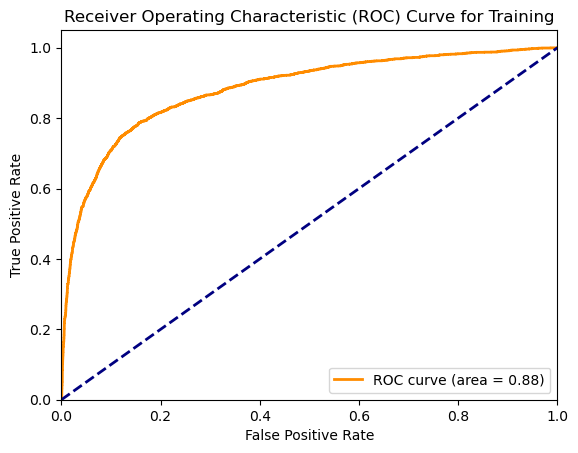

AUROC for Validation: 0.88


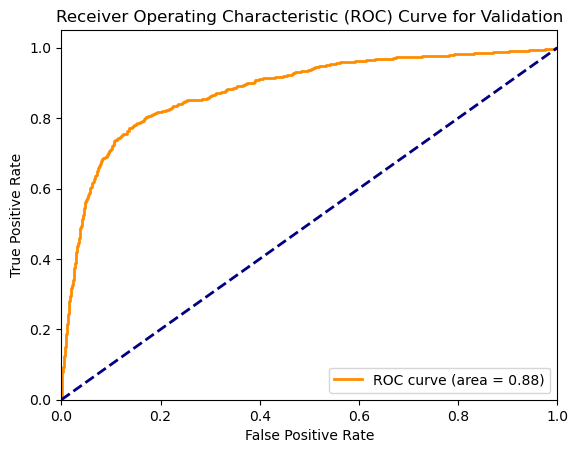

In [23]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

AUROC Високий і площа під кривою теж - модель хороша. Валідаційні дані трошки гірше прогнозує (видно по формі кривої), але це не якісна похибка

In [24]:
print('Тренувальні дані')
print(f1_score(train_targets, train_preds))
print('Валідаційні дані')
print(f1_score(val_targets, val_preds))

Тренувальні дані
0.6378600823045267
Валідаційні дані
0.6338880484114978


Гармонійне середнє > 0.5 і це показує що класифікатор хороший

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [25]:
print(get_key_count_dict(train_df['Exited']))

{0.0: 11948, 1.0: 3052}


In [26]:
print('Модель прогнозування завжди переважного класу')
print('Тренувальні дані')
print(accuracy_score(train_targets, np.full(len(train_targets), 0.0)))
print('Валідаційні дані')
print(accuracy_score(val_targets, np.full(len(val_targets), 0.0)))

Модель прогнозування завжди переважного класу
Тренувальні дані
0.7965333333333333
Валідаційні дані
0.7965333333333333


In [27]:
print('Натренована модель')
print('Тренувальні дані')
print(accuracy_score(train_targets, train_preds))
print('Валідаційні дані')
print(accuracy_score(val_targets, val_preds))

Натренована модель
Тренувальні дані
0.8748444444444444
Валідаційні дані
0.8709333333333333


Навчена модель краще прогнозує клас ніж вибір завжди переважного класу

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [30]:
model_for_saving = {'numeric_bool_cols':numeric_bool_cols,
                    'numeric_cols_for_scal':numeric_cols_for_scal,
                    'categorical_bool_cols':categorical_bool_cols,
                    'categorical_encode_cols':categorical_encode_cols,
                    'scaler':scaler,
                    'enc':enc,
                    'encoder':encoder,
                    'model':model}
joblib.dump(model_for_saving, 'log_reg.joblib')

['log_reg.joblib']

In [31]:
os.listdir()

['train_inputs.parquet',
 'train.csv.zip',
 'val_inputs.parquet',
 'log_reg.joblib',
 'test.csv',
 '.ipynb_checkpoints',
 'HW_2_7_Логістична_регресія_з_scikit_learn.ipynb']

In [32]:
model_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [33]:
import warnings
warnings.filterwarnings("ignore")

def predict_df(scaler, enc, encoder, model,
               numeric_bool_cols, numeric_cols_for_scal,
               categorical_bool_cols, categorical_encode_cols,
               input_df: pd.DataFrame):
    input_df[numeric_cols_for_scal] = scaler.transform(input_df[numeric_cols_for_scal])
    input_df[categorical_bool_cols] = enc.fit_transform(input_df[categorical_bool_cols])
    encoded_cols = list(encoder.get_feature_names_out(categorical_encode_cols))
    input_df[encoded_cols] = encoder.transform(input_df[categorical_encode_cols])
    X_input = input_df[numeric_bool_cols + numeric_cols_for_scal +
                       encoded_cols + categorical_bool_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [37]:
predict_df(scaler, enc, encoder, model,
              numeric_bool_cols, numeric_cols_for_scal,
              categorical_bool_cols, categorical_encode_cols,
           train_df[:10])

array([0.00645988, 0.0373201 , 0.36812947, 0.3757525 , 0.97564942,
       0.02926933, 0.13476123, 0.01405009, 0.97274781, 0.04517362])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [38]:
test_raw_df = pd.read_csv('test.csv')
test_raw_df['Exited'] = predict_df(scaler, enc, encoder, model,
              numeric_bool_cols, numeric_cols_for_scal,
              categorical_bool_cols, categorical_encode_cols,
           test_raw_df)

In [40]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
0,15000,15594796.0,Chu,0.365155,Germany,1.0,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,0.075414
1,15001,15642821.0,Mazzi,0.286396,France,1.0,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131,1.0,0.0,0.0,0.034874
2,15002,15716284.0,Onyekachi,0.656325,France,1.0,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859,1.0,0.0,0.0,0.150595
3,15003,15785078.0,Martin,0.682578,Spain,1.0,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,0.0,1.0,0.196202
4,15004,15662955.0,Kenechukwu,0.384248,Spain,1.0,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,0.0,1.0,0.055233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,0.496420,Spain,1.0,0.357143,1.0,0.000000,0.333333,1.0,1.0,0.248154,0.0,0.0,1.0,0.022174
9996,24996,15739271.0,Clements,0.589499,Spain,1.0,0.375000,0.9,0.000000,0.333333,1.0,1.0,0.712578,0.0,0.0,1.0,0.026046
9997,24997,15756743.0,Chidiebere,0.818616,France,1.0,0.214286,0.9,0.000000,0.333333,1.0,0.0,0.024253,1.0,0.0,0.0,0.018608
9998,24998,15680167.0,Yermakova,0.391408,France,1.0,0.357143,0.6,0.690650,0.000000,1.0,0.0,0.632348,1.0,0.0,0.0,0.152418


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [50]:
submision_df = pd.read_csv('sample_submission.csv')
submision_df

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5
...,...,...
9995,24995,0.5
9996,24996,0.5
9997,24997,0.5
9998,24998,0.5


In [51]:
submision_df = pd.merge(submision_df, test_raw_df[['id', 'Exited']], 
                        on='id')[['id', 'Exited_y']]
submision_df.columns = [['id', 'Exited']]
submision_df

,id,Exited
0,15000,0.075414
1,15001,0.034874
2,15002,0.150595
3,15003,0.196202
4,15004,0.055233
...,...,...
9995,24995,0.022174
9996,24996,0.026046
9997,24997,0.018608
9998,24998,0.152418


In [53]:
submision_df.to_csv('submision_pred.csv', index=False)